<a href="https://colab.research.google.com/github/Sinhavaishnavi/CODE_CRAFT_ML/blob/main/CLASSIFYIMAGEOFDOG%26CATUSINGSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# This will prompt you to upload a file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vaishnavisinha12","key":"1f2a3ebed25faf11360800a888408157"}'}

In [3]:
# Create a directory named .kaggle
!mkdir -p ~/.kaggle

# Move the uploaded kaggle.json file to that directory
!cp kaggle.json ~/.kaggle/

# Set the required permissions for the file to be read by the owner only
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download the dataset from Kaggle
!kaggle competitions download -c dogs-vs-cats

# Unzip the main file and the train/test archives
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

 98% 792M/812M [00:05<00:00, 96.5MB/s]
100% 812M/812M [00:05<00:00, 165MB/s] 


In [7]:
import os
import random

# Define the training directory
train_dir = 'train/'

# Create a list of all training image filenames
all_filenames = os.listdir(train_dir)

# Create a balanced subset with 1000 cats and 1000 dogs
cat_files = [f for f in all_filenames if f.startswith('cat')]
dog_files = [f for f in all_filenames if f.startswith('dog')]

filenames = random.sample(cat_files, 1000) + random.sample(dog_files, 1000)
labels = ['cat'] * 1000 + ['dog'] * 1000

In [8]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tqdm import tqdm

# Load the MobileNetV2 model, excluding its final classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

features_list = []
for filename in tqdm(filenames, desc="Extracting Features"):
    img_path = os.path.join(train_dir, filename)

    # Load and preprocess each image to match the model's requirements
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # Extract features and append to our list
    features = base_model.predict(img_preprocessed, verbose=0)
    features_list.append(features.flatten())

# Convert the list of features and labels into NumPy arrays
X = np.array(features_list)
y = np.array(labels)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting Features: 100%|██████████| 2000/2000 [06:53<00:00,  4.83it/s]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features. This is crucial for SVM performance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVM model
print("\nTraining SVM classifier...")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Make predictions and evaluate the model's performance
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training SVM classifier...
Training complete.

Model Accuracy: 99.25%

Classification Report:
              precision    recall  f1-score   support

         cat       0.99      0.99      0.99       200
         dog       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



Displaying Confusion Matrix...


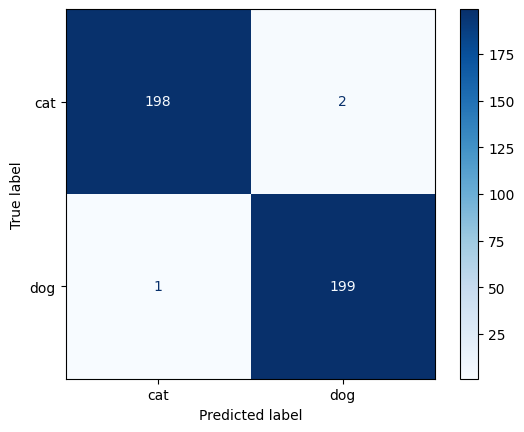

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix using the test data and predictions
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

print("Displaying Confusion Matrix...")
disp.plot(cmap=plt.cm.Blues)
plt.show()

Predicting for image: 4363.jpg


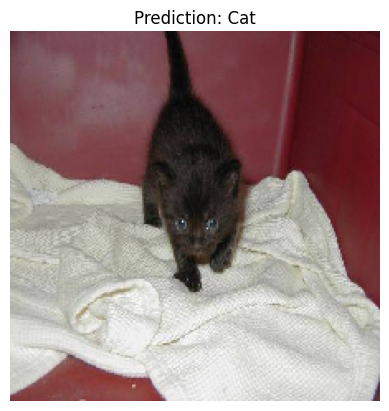

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

# 1. Select a random test image
test_dir = 'test1/'
random_image_name = random.choice(os.listdir(test_dir))
image_path = os.path.join(test_dir, random_image_name)

print(f"Predicting for image: {random_image_name}")

# 2. Load and preprocess the image in the same way as the training data
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded)

# 3. Extract features using the CNN model
new_features = base_model.predict(img_preprocessed, verbose=0)

# 4. Scale the features using the *same scaler* from training
new_features_scaled = scaler.transform(new_features)

# 5. Make the final prediction with the SVM model
prediction = svm_model.predict(new_features_scaled)
predicted_class = prediction[0]

# 6. Display the image and the prediction
plt.imshow(img)
plt.title(f'Prediction: {predicted_class.capitalize()}')
plt.axis('off')
plt.show()

In [12]:
import joblib

# Define filenames for your components
svm_model_filename = 'svm_cat_dog_classifier.joblib'
scaler_filename = 'feature_scaler.joblib'

# Save the SVM model
print(f"Saving SVM model to {svm_model_filename}...")
joblib.dump(svm_model, svm_model_filename)

# Save the feature scaler
print(f"Saving scaler to {scaler_filename}...")
joblib.dump(scaler, scaler_filename)

print("\nModel and scaler saved successfully! 🎉")

Saving SVM model to svm_cat_dog_classifier.joblib...
Saving scaler to feature_scaler.joblib...

Model and scaler saved successfully! 🎉


Please upload a cat or dog image:


Saving images.jpeg to images.jpeg


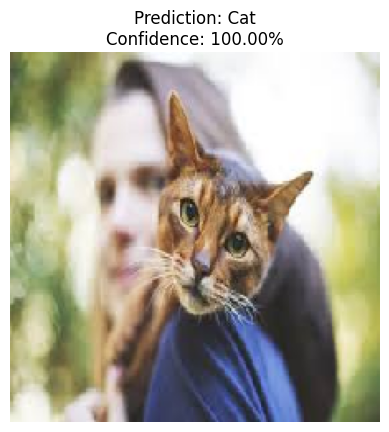

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing import image

# 1. Prompt user to upload an image
print("Please upload a cat or dog image:")
uploaded = files.upload()

# Check if an image was uploaded
if not uploaded:
    print("No image was uploaded. Please run the cell again.")
else:
    # Get the filename of the uploaded image
    filename = next(iter(uploaded))

    # 2. Load and preprocess the uploaded image
    img = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # 3. Extract and scale features (using your trained models)
    new_features = base_model.predict(img_preprocessed, verbose=0)
    new_features_scaled = scaler.transform(new_features)

    # 4. Get prediction probabilities
    probabilities = svm_model.predict_proba(new_features_scaled)[0]

    # 5. Get the predicted class and the confidence score
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = svm_model.classes_[predicted_class_index]
    confidence_score = np.max(probabilities)

    # 6. Display the image and the result
    plt.imshow(img)
    title_text = f"Prediction: {predicted_class_name.capitalize()}\nConfidence: {confidence_score:.2%}"
    plt.title(title_text)
    plt.axis('off')
    plt.show()

In [1]:
!pip install ultralytics

Please upload an image to count cats and dogs:


Saving download (2).jpeg to download (2) (1).jpeg

image 1/1 /content/download (2) (1).jpeg: 352x640 3 cats, 3 dogs, 1 tie, 919.5ms
Speed: 2.9ms preprocess, 919.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

--- Detection Results ---
Found 3 cat(s).
Found 3 dog(s).

Displaying image with detections:


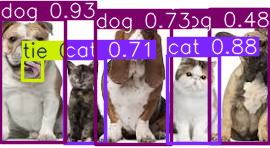

In [5]:
# 1. Install the required library
!pip install -q ultralytics

from ultralytics import YOLO
from PIL import Image
from google.colab import files
from IPython.display import display

# 2. Load a pre-trained object detection model
model = YOLO('yolov8m.pt')

# 3. Prompt the user to upload an image
print("Please upload an image to count cats and dogs:")
uploaded = files.upload()

if not uploaded:
    print("\nNo image was uploaded.")
else:
    # Get the filename of the uploaded image
    filename = next(iter(uploaded))

    # 4. Run detection on the uploaded image
    results = model(filename)

    # 5. Process results to specifically count cats and dogs
    print("\n--- Detection Results ---")
    cat_count = 0
    dog_count = 0

    # Loop through all detected objects
    for box in results[0].boxes:
        # Get the class name of the detected object
        class_name = model.names[int(box.cls)]

        # Check if the object is a cat or a dog and increment the counter
        if class_name == 'cat':
            cat_count += 1
        elif class_name == 'dog':
            dog_count += 1

    # Print the final counts
    print(f"Found {cat_count} cat(s).")
    print(f"Found {dog_count} dog(s).")

    # 6. Display the image with bounding boxes
    print("\nDisplaying image with detections:")
    result_image_array = results[0].plot()
    display(Image.fromarray(result_image_array[:, :, ::-1]))